# Initial Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Loading Dataset

In [ ]:
import os
import gdown
from zipfile import ZipFile

# Replace 'your_google_drive_link' with the actual link to your shared Google Drive zip file
google_drive_link = 'https://drive.google.com/uc?export=download&id=1-u-zf1-Lf8CVWOGoLeYFITAAiQ_m8RU3'
download_path = '/content/Roman.zip'

# Download the zip file from Google Drive
gdown.download(google_drive_link, download_path, quiet=False)

# Extract the contents of the zip file
with ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Set the path to your dataset
root_folder_path = '/content/Dataset'  # Adjust to the actual folder name after extraction

# Get a list of poet folders
poet_folders = [folder for folder in os.listdir(root_folder_path) if os.path.isdir(os.path.join(root_folder_path, folder))]

# Initialize empty lists to store poems and labels
poems1 = []
labels = []

# Read poems and assign labels based on folder names
for label, poet_folder in enumerate(poet_folders):
    poet_folder_path = os.path.join(root_folder_path, poet_folder)

    # Assuming each text file in the poet's folder contains a poem
    poem_files = [file for file in os.listdir(poet_folder_path) if file.endswith('.txt')]

    for poem_file in poem_files:
        poem_file_path = os.path.join(poet_folder_path, poem_file)

        with open(poem_file_path, 'r', encoding='utf-8') as file:
            poem_text = file.read()

        poems1.append(poem_text)
        labels.append(label)

poems = [entry.replace('\t', '').replace('\n\n', '\n') for entry in poems1]

# Print the cleaned data
print(labels)
print(poems)
print('\n')

Downloading...
From: https://drive.google.com/uc?export=download&id=1-u-zf1-Lf8CVWOGoLeYFITAAiQ_m8RU3
To: /content/Roman.zip
100%|██████████| 478k/478k [00:00<00:00, 54.1MB/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

# Bert Embeddings

In [ ]:
#BERT EMBEDDINGS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Split the dataset into training and testing sets
poems_train, poems_temp, labels_train, labels_temp = train_test_split(poems, labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

# Load the tokenizer and model (using DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')


# Save training embeddings
for i, poem_text in enumerate(poems_train):
    # Tokenize and encode the poem
    poem_batch_dict = tokenizer(poem_text, padding=True, truncation=True, return_tensors='pt', max_length=80)

    # Generate the embedding
    poem_output = model(**poem_batch_dict)
    poem_embedding = poem_output.last_hidden_state.mean(dim=1).to(device)

    # Save the embedding
    torch.save(poem_embedding, f'train_embedding_{i}.pt')

# Save validation embeddings
for i, poem_text in enumerate(poems_val):
    # Tokenize and encode the poem
    poem_batch_dict = tokenizer(poem_text, padding=True, truncation=True, return_tensors='pt', max_length=80)

    # Generate the embedding
    poem_output = model(**poem_batch_dict)
    poem_embedding = poem_output.last_hidden_state.mean(dim=1).to(device)

    # Save the embedding
    torch.save(poem_embedding, f'val_embedding_{i}.pt')

# Save test embeddings
for i, poem_text in enumerate(poems_test):
    # Tokenize and encode the poem
    poem_batch_dict = tokenizer(poem_text, padding=True, truncation=True, return_tensors='pt', max_length=80)

    # Generate the embedding
    poem_output = model(**poem_batch_dict)
    poem_embedding = poem_output.last_hidden_state.mean(dim=1).to(device)

    # Save the embedding
    torch.save(poem_embedding, f'test_embedding_{i}.pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [ ]:
class_labels = sorted(list(set(labels_train)))
# Assuming you've already loaded and preprocessed your data
# Load the saved embeddings
def load_embeddings(prefix, num_embeddings):
    embeddings = []
    for i in range(num_embeddings):
        file_path = f'{prefix}_{i}.pt'
        embedding = torch.load(file_path)
        embeddings.append(embedding)
    return torch.stack(embeddings)

train_embeddings = load_embeddings('train_embedding', len(poems_train))
val_embeddings = load_embeddings('val_embedding', len(poems_val))
test_embeddings = load_embeddings('test_embedding', len(poems_test))

# Convert labels to PyTorch tensors
train_labels = torch.tensor(labels_train)
val_labels = torch.tensor(labels_val)
test_labels = torch.tensor(labels_test)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

train_embeddings_np = train_embeddings.detach().numpy()
val_embeddings_np = val_embeddings.detach().numpy()
test_embeddings_np = test_embeddings.detach().numpy()
labels_train_np = np.array(labels_train)
labels_val_np = np.array(labels_val)
labels_test_np = np.array(labels_test)

# Bert with embeddings

Epoch [1/100], Loss: 2.1554, Validation Loss: 1.9148
Epoch [2/100], Loss: 1.7501, Validation Loss: 1.7875
Epoch [3/100], Loss: 1.8895, Validation Loss: 1.6837
Epoch [4/100], Loss: 1.9923, Validation Loss: 1.5961
Epoch [5/100], Loss: 1.5473, Validation Loss: 1.5127
Epoch [6/100], Loss: 1.8608, Validation Loss: 1.4347
Epoch [7/100], Loss: 1.4392, Validation Loss: 1.3919
Epoch [8/100], Loss: 1.2115, Validation Loss: 1.3207
Epoch [9/100], Loss: 1.0054, Validation Loss: 1.2738
Epoch [10/100], Loss: 1.0296, Validation Loss: 1.2311
Epoch [11/100], Loss: 0.6626, Validation Loss: 1.1993
Epoch [12/100], Loss: 1.0857, Validation Loss: 1.1612
Epoch [13/100], Loss: 1.4237, Validation Loss: 1.1178
Epoch [14/100], Loss: 1.1485, Validation Loss: 1.0951
Epoch [15/100], Loss: 0.8343, Validation Loss: 1.0573
Epoch [16/100], Loss: 0.9019, Validation Loss: 1.0285
Epoch [17/100], Loss: 1.1145, Validation Loss: 1.0059
Epoch [18/100], Loss: 0.8240, Validation Loss: 0.9789
Epoch [19/100], Loss: 0.9612, Validat

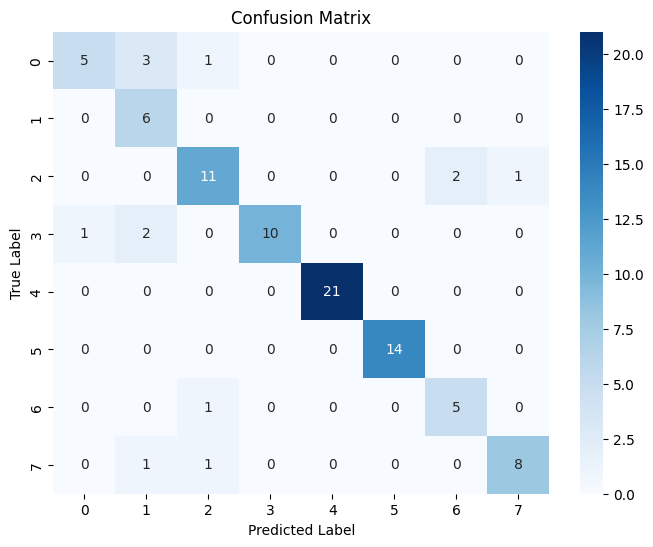

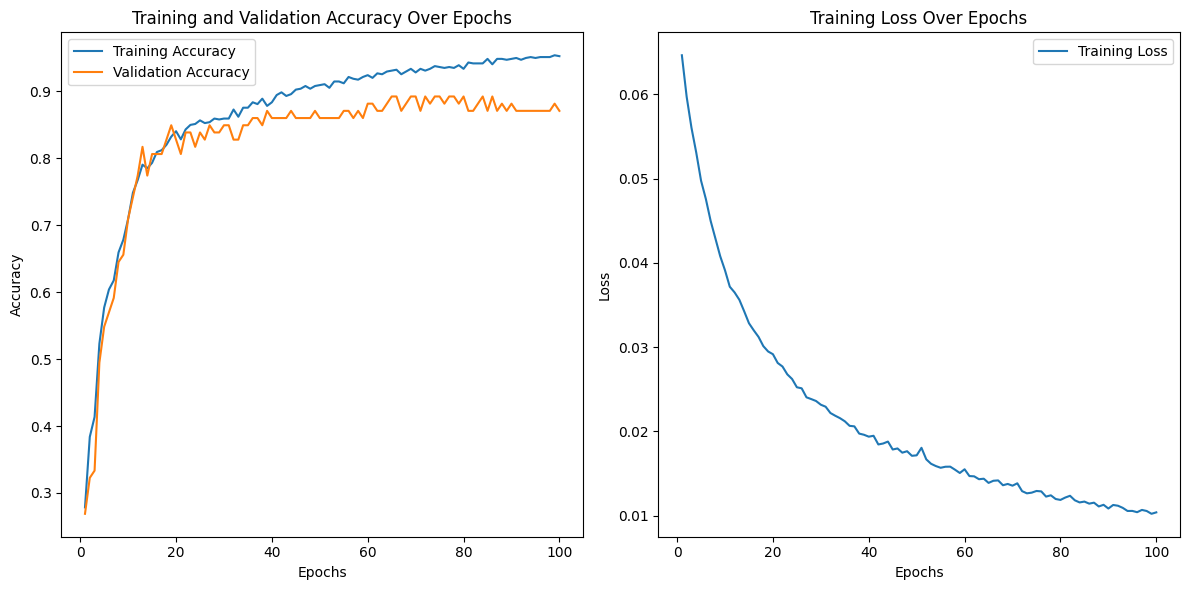

In [ ]:
#BERT WITH BERT

class PoemClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoemClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten along the sequence length dimension
        x = F.relu(x)
        x = self.fc(x)
        return x

# Set the input size based on the size of the embeddings
input_size = train_embeddings.size(2)  # Use size(2) instead of size(1)

# Initialize the classifier and move it to the device
classifier = PoemClassifier(input_size, len(set(labels)))
classifier.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create DataLoader for training to iterate over the embeddings and labels in batches.
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



# ... (previous code remains unchanged)
val_accuracies = []
train_accuracies = []
best_val_loss = float('inf')
patience = 5  # You can adjust this based on your needs
counter = 0
train_losses = []  # Track training loss
val_losses = []

# Training loop with early stopping
num_epochs = 100
for epoch in range(num_epochs):
    classifier.train()
    epoch_loss=0

    for batch_embeddings, batch_labels in train_loader:
      batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

      # Forward pass
      outputs = classifier(batch_embeddings)
      loss = criterion(outputs, batch_labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    # Average training loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Training accuracy
    with torch.no_grad():
        classifier.eval()
        train_outputs = classifier(train_embeddings.to(device))
        train_probabilities = F.softmax(train_outputs, dim=1)
        train_predicted_labels = torch.argmax(train_probabilities, dim=1).tolist()
        train_accuracy = accuracy_score(train_labels, train_predicted_labels)
        train_accuracies.append(train_accuracy)
    # Validation
    with torch.no_grad():
        classifier.eval()
        val_outputs = classifier(val_embeddings.to(device))
        val_loss = criterion(val_outputs, val_labels.to(device))
        val_losses.append(val_loss.item())


        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1


        val_probabilities = F.softmax(val_outputs, dim=1)
        val_predicted_labels = torch.argmax(val_probabilities, dim=1).tolist()
        val_accuracy = accuracy_score(val_labels, val_predicted_labels)
        val_accuracies.append(val_accuracy)

        # Print the current status
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered!")
            break



# Evaluation on the test set
with torch.no_grad():
    classifier.eval()
    test_outputs = classifier(test_embeddings.to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))

    # Convert logits to probabilities
    test_probabilities = F.softmax(test_outputs, dim=1)

    # Get the predicted labels
    test_predicted_labels = torch.argmax(test_probabilities, dim=1).tolist()

    cm = confusion_matrix(test_labels, test_predicted_labels)
    # Calculate accuracy for test set
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f'Test Accuracy: {test_accuracy:.4f}')

#simple plot code

# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plot accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Bert with tf-idf

Epoch [1/100], Loss: 0.1306, Validation Loss: 2.0210
Epoch [2/100], Loss: 0.1254, Validation Loss: 1.9620
Epoch [3/100], Loss: 0.1206, Validation Loss: 1.9052
Epoch [4/100], Loss: 0.1156, Validation Loss: 1.8496
Epoch [5/100], Loss: 0.1111, Validation Loss: 1.7955
Epoch [6/100], Loss: 0.1065, Validation Loss: 1.7436
Epoch [7/100], Loss: 0.1023, Validation Loss: 1.6940
Epoch [8/100], Loss: 0.0980, Validation Loss: 1.6454
Epoch [9/100], Loss: 0.0943, Validation Loss: 1.5988
Epoch [10/100], Loss: 0.0905, Validation Loss: 1.5541
Epoch [11/100], Loss: 0.0866, Validation Loss: 1.5118
Epoch [12/100], Loss: 0.0828, Validation Loss: 1.4705
Epoch [13/100], Loss: 0.0797, Validation Loss: 1.4302
Epoch [14/100], Loss: 0.0762, Validation Loss: 1.3918
Epoch [15/100], Loss: 0.0733, Validation Loss: 1.3551
Epoch [16/100], Loss: 0.0701, Validation Loss: 1.3197
Epoch [17/100], Loss: 0.0674, Validation Loss: 1.2852
Epoch [18/100], Loss: 0.0645, Validation Loss: 1.2523
Epoch [19/100], Loss: 0.0621, Validat

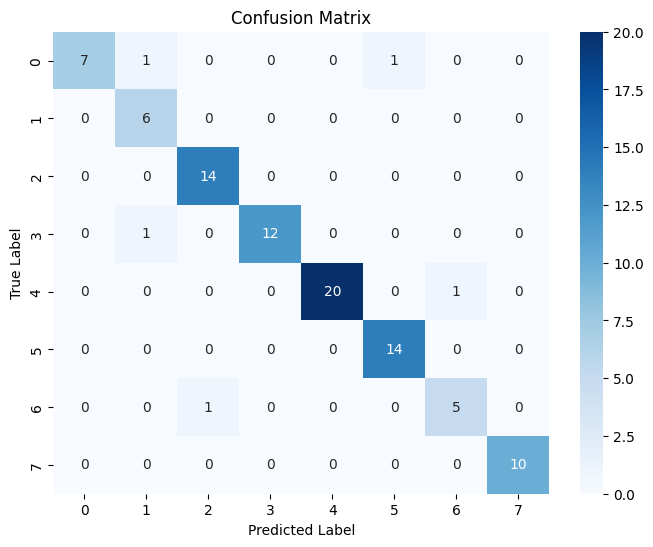

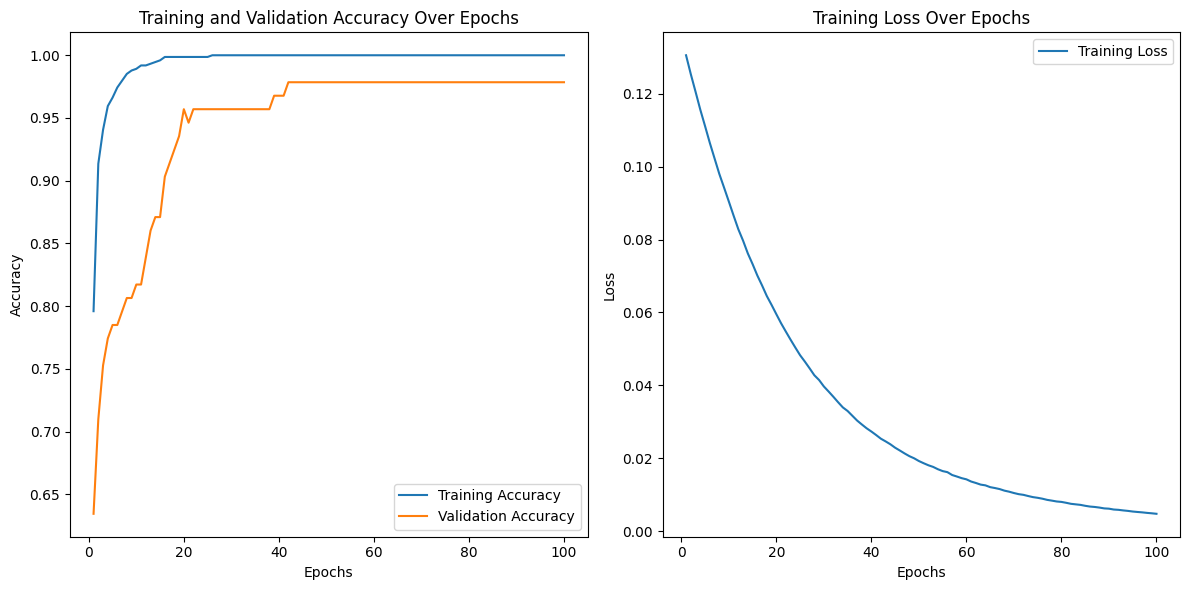

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Split the dataset into training, validation, and test sets
poems_train, poems_temp, labels_train, labels_temp = train_test_split(poems, labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

# Fit and transform the poems for training data
train_tfidf = tfidf_vectorizer.fit_transform(poems_train).toarray()

# Transform the poems for validation and test data
val_tfidf = tfidf_vectorizer.transform(poems_val).toarray()
test_tfidf = tfidf_vectorizer.transform(poems_test).toarray()

# Convert labels to PyTorch tensors
train_labels = torch.tensor(labels_train)
val_labels = torch.tensor(labels_val)
test_labels = torch.tensor(labels_test)

class PoemClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoemClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = F.relu(x)
        x = self.fc(x)
        return x

# Set the input size based on the size of the TF-IDF vectors
input_size = train_tfidf.shape[1]

# Initialize the classifier and move it to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = PoemClassifier(input_size, len(set(labels)))
classifier.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create DataLoader for training
train_dataset = TensorDataset(torch.tensor(train_tfidf, dtype=torch.float), train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    classifier.train()
    epoch_loss = 0

    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # Forward pass
        outputs = classifier(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average training loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Training accuracy
    with torch.no_grad():
        classifier.eval()
        train_outputs = classifier(torch.tensor(train_tfidf, dtype=torch.float).to(device))
        train_predicted_labels = torch.argmax(train_outputs, dim=1).tolist()
        train_accuracy = accuracy_score(train_labels, train_predicted_labels)
        train_accuracies.append(train_accuracy)

    # Validation
    with torch.no_grad():
        classifier.eval()
        val_outputs = classifier(torch.tensor(val_tfidf, dtype=torch.float).to(device))
        val_loss = criterion(val_outputs, val_labels.to(device))
        val_losses.append(val_loss.item())

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        val_predicted_labels = torch.argmax(val_outputs, dim=1).tolist()
        val_accuracy = accuracy_score(val_labels, val_predicted_labels)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Evaluation on the test set
with torch.no_grad():
    classifier.eval()
    test_outputs = classifier(torch.tensor(test_tfidf, dtype=torch.float).to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))

    test_predicted_labels = torch.argmax(test_outputs, dim=1).tolist()
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Calculate confusion matrix for test set
    cm = confusion_matrix(test_labels, test_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(labels)), yticklabels=list(set(labels)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# LSTM with embeddings

Epoch 1/80
24/24 [==============================] - 7s 52ms/step - loss: 1.8964 - accuracy: 0.2811 - val_loss: 1.6030 - val_accuracy: 0.3226
Epoch 2/80
24/24 [==============================] - 0s 9ms/step - loss: 1.3451 - accuracy: 0.5811 - val_loss: 1.1198 - val_accuracy: 0.5699
Epoch 3/80
24/24 [==============================] - 0s 8ms/step - loss: 0.9712 - accuracy: 0.6892 - val_loss: 0.8408 - val_accuracy: 0.7849
Epoch 4/80
24/24 [==============================] - 0s 8ms/step - loss: 0.7709 - accuracy: 0.7649 - val_loss: 0.7818 - val_accuracy: 0.7204
Epoch 5/80
24/24 [==============================] - 0s 8ms/step - loss: 0.6387 - accuracy: 0.8351 - val_loss: 0.6144 - val_accuracy: 0.8495
Epoch 6/80
24/24 [==============================] - 0s 8ms/step - loss: 0.5374 - accuracy: 0.8581 - val_loss: 0.5622 - val_accuracy: 0.8710
Epoch 7/80
24/24 [==============================] - 0s 9ms/step - loss: 0.4733 - accuracy: 0.8838 - val_loss: 0.5110 - val_accuracy: 0.8817
Epoch 8/80
24/24 [=

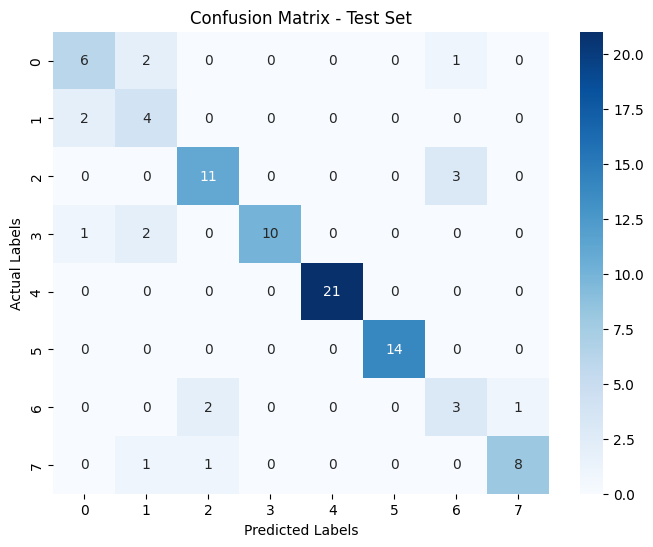

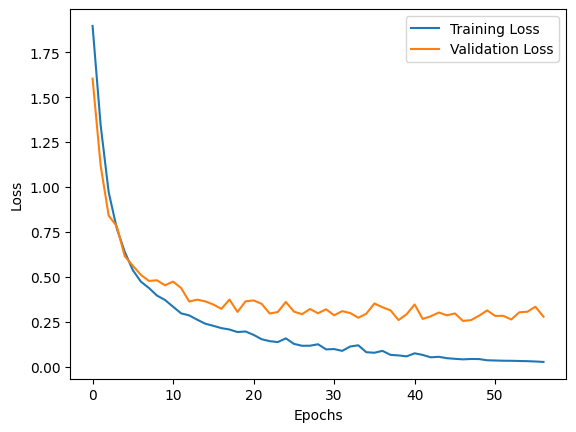

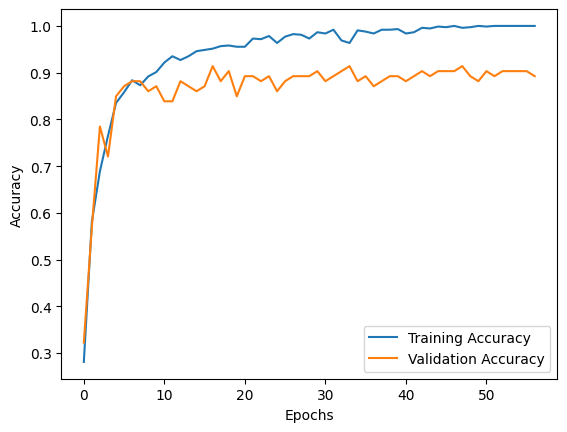

In [ ]:
model = Sequential()
# model.add(Embedding(input_dim=len(vocab) + 1, output_dim=50, input_length=max_seq_length))
model.add(Bidirectional(LSTM(30)))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_embeddings_np, labels_train_np, validation_data=(val_embeddings_np, labels_val_np),
                    epochs=80, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
# Evaluate the model on the test set
test_probabilities = model.predict(test_embeddings_np)
test_predictions = np.argmax(test_probabilities, axis=1)
test_accuracy = accuracy_score(labels_test_np, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# LSTM with tf-idf

Epoch 1/80
24/24 [==============================] - 7s 63ms/step - loss: 2.0633 - accuracy: 0.3135 - val_loss: 2.0366 - val_accuracy: 0.3871
Epoch 2/80
24/24 [==============================] - 0s 20ms/step - loss: 1.9934 - accuracy: 0.4932 - val_loss: 1.9723 - val_accuracy: 0.3978
Epoch 3/80
24/24 [==============================] - 0s 19ms/step - loss: 1.8896 - accuracy: 0.5405 - val_loss: 1.8728 - val_accuracy: 0.4624
Epoch 4/80
24/24 [==============================] - 0s 20ms/step - loss: 1.7344 - accuracy: 0.6716 - val_loss: 1.7289 - val_accuracy: 0.5806
Epoch 5/80
24/24 [==============================] - 0s 19ms/step - loss: 1.5202 - accuracy: 0.8324 - val_loss: 1.5426 - val_accuracy: 0.7204
Epoch 6/80
24/24 [==============================] - 0s 19ms/step - loss: 1.2594 - accuracy: 0.9392 - val_loss: 1.3266 - val_accuracy: 0.8280
Epoch 7/80
24/24 [==============================] - 0s 20ms/step - loss: 0.9823 - accuracy: 0.9865 - val_loss: 1.1094 - val_accuracy: 0.8925
Epoch 8/80
24

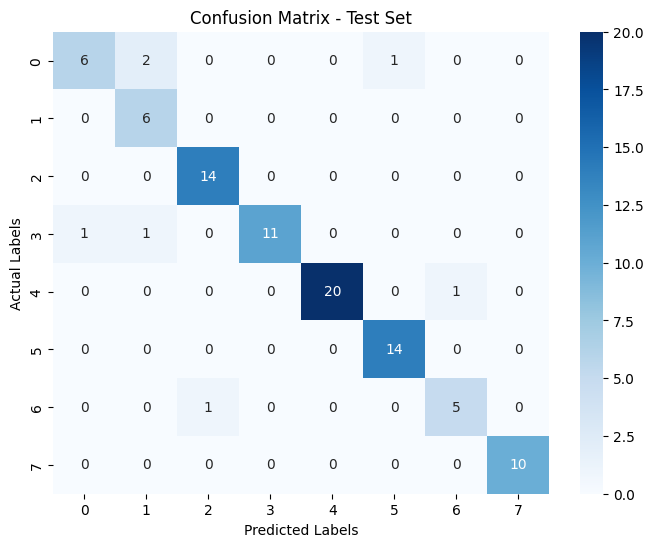

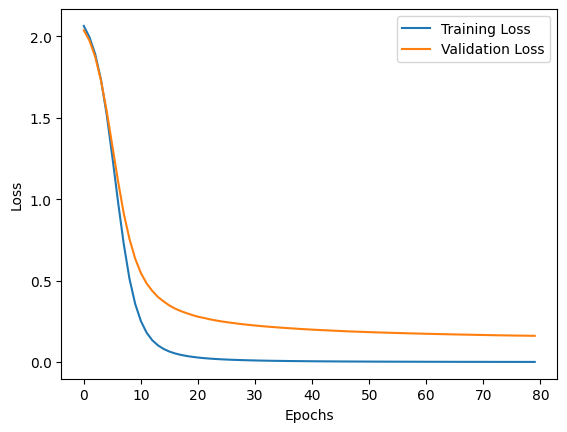

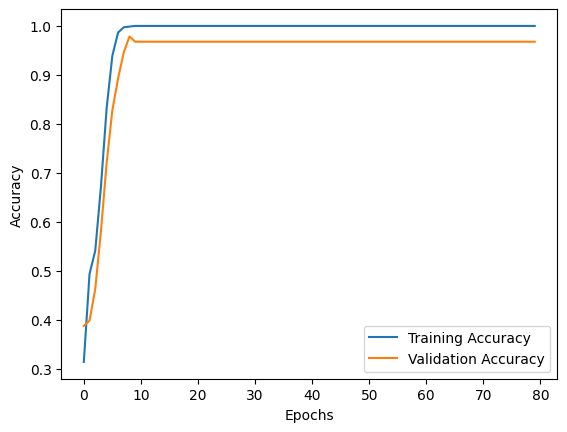

In [ ]:
#LSTM WITH TF-IDF
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
poems_train, poems_temp, labels_train, labels_temp = train_test_split(poems, encoded_labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

# Convert poems to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
poems_train_tfidf = vectorizer.fit_transform(poems_train).toarray()
poems_val_tfidf = vectorizer.transform(poems_val).toarray()
poems_test_tfidf = vectorizer.transform(poems_test).toarray()


# Reshape input data to have a third dimension (timesteps)
poems_train_tfidf = poems_train_tfidf.reshape(poems_train_tfidf.shape[0], 1, poems_train_tfidf.shape[1])
poems_val_tfidf = poems_val_tfidf.reshape(poems_val_tfidf.shape[0], 1, poems_val_tfidf.shape[1])
poems_test_tfidf = poems_test_tfidf.reshape(poems_test_tfidf.shape[0], 1, poems_test_tfidf.shape[1])

# Define the Keras LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(30)))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(poems_train_tfidf, labels_train, validation_data=(poems_val_tfidf, labels_val),
                    epochs=80, batch_size=32, callbacks=[early_stopping])


# Evaluate the model on the test set
test_probabilities = model.predict(poems_test_tfidf)
test_predictions = np.argmax(test_probabilities, axis=1)
test_accuracy = accuracy_score(labels_test, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# GRU with embeddings

Epoch 1/80
24/24 [==============================] - 7s 43ms/step - loss: 1.7487 - accuracy: 0.3932 - val_loss: 1.4336 - val_accuracy: 0.5161
Epoch 2/80
24/24 [==============================] - 0s 8ms/step - loss: 1.1630 - accuracy: 0.6081 - val_loss: 1.0575 - val_accuracy: 0.6882
Epoch 3/80
24/24 [==============================] - 0s 7ms/step - loss: 0.8980 - accuracy: 0.7284 - val_loss: 0.7790 - val_accuracy: 0.8172
Epoch 4/80
24/24 [==============================] - 0s 7ms/step - loss: 0.7143 - accuracy: 0.7959 - val_loss: 0.7247 - val_accuracy: 0.7419
Epoch 5/80
24/24 [==============================] - 0s 7ms/step - loss: 0.5799 - accuracy: 0.8622 - val_loss: 0.6304 - val_accuracy: 0.8495
Epoch 6/80
24/24 [==============================] - 0s 8ms/step - loss: 0.4928 - accuracy: 0.8676 - val_loss: 0.5313 - val_accuracy: 0.8817
Epoch 7/80
24/24 [==============================] - 0s 8ms/step - loss: 0.4408 - accuracy: 0.8797 - val_loss: 0.4806 - val_accuracy: 0.8817
Epoch 8/80
24/24 [=

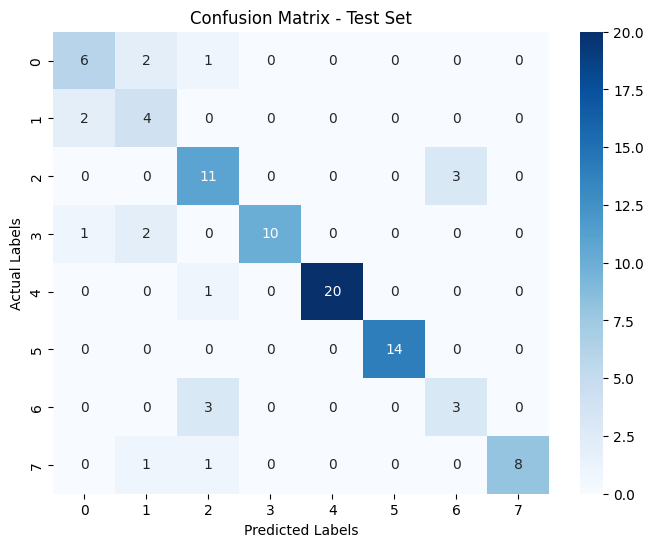

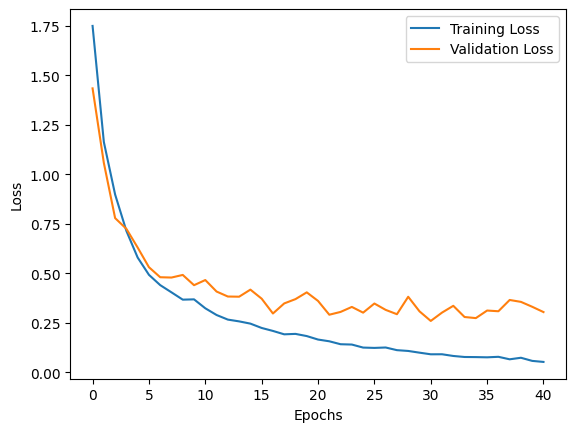

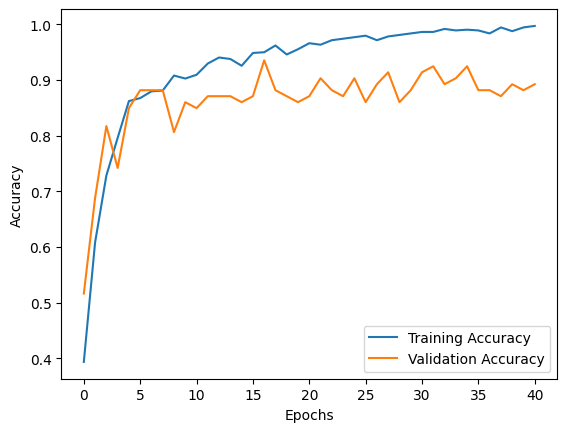

In [ ]:
# Define the Keras GRU model
model = Sequential()
model.add(Bidirectional(GRU(30)))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_embeddings_np, labels_train_np, validation_data=(val_embeddings_np, labels_val_np),
                    epochs=80, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
test_probabilities = model.predict(test_embeddings_np)
test_predictions = np.argmax(test_probabilities, axis=1)
test_accuracy = accuracy_score(labels_test_np, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# GRU with tf-idf

Epoch 1/80
24/24 [==============================] - 7s 112ms/step - loss: 2.0435 - accuracy: 0.3297 - val_loss: 1.9890 - val_accuracy: 0.3226
Epoch 2/80
24/24 [==============================] - 1s 35ms/step - loss: 1.9031 - accuracy: 0.4068 - val_loss: 1.8701 - val_accuracy: 0.3548
Epoch 3/80
24/24 [==============================] - 1s 35ms/step - loss: 1.7193 - accuracy: 0.5432 - val_loss: 1.7062 - val_accuracy: 0.4516
Epoch 4/80
24/24 [==============================] - 1s 35ms/step - loss: 1.4810 - accuracy: 0.7622 - val_loss: 1.4991 - val_accuracy: 0.6989
Epoch 5/80
24/24 [==============================] - 1s 48ms/step - loss: 1.2012 - accuracy: 0.9068 - val_loss: 1.2742 - val_accuracy: 0.8495
Epoch 6/80
24/24 [==============================] - 1s 48ms/step - loss: 0.9138 - accuracy: 0.9797 - val_loss: 1.0513 - val_accuracy: 0.9140
Epoch 7/80
24/24 [==============================] - 1s 45ms/step - loss: 0.6581 - accuracy: 0.9986 - val_loss: 0.8619 - val_accuracy: 0.9570
Epoch 8/80
2

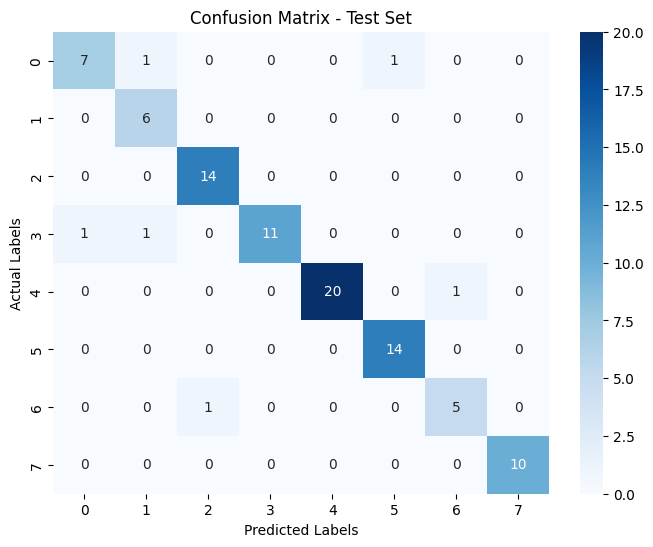

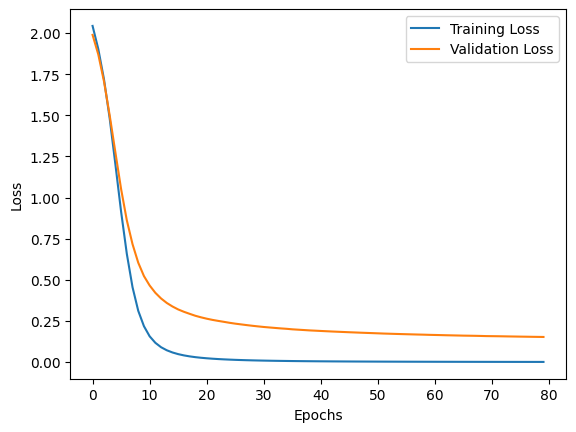

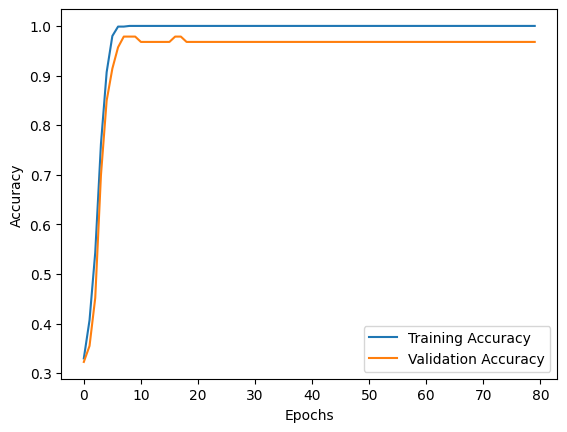

In [ ]:
from keras.layers import Dense, GRU, Bidirectional
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
poems_train, poems_temp, labels_train, labels_temp = train_test_split(poems, encoded_labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

# Convert poems to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
poems_train_tfidf = vectorizer.fit_transform(poems_train).toarray()
poems_val_tfidf = vectorizer.transform(poems_val).toarray()
poems_test_tfidf = vectorizer.transform(poems_test).toarray()

# Reshape input data to have a third dimension (timesteps)
poems_train_tfidf = poems_train_tfidf.reshape(poems_train_tfidf.shape[0], 1, poems_train_tfidf.shape[1])
poems_val_tfidf = poems_val_tfidf.reshape(poems_val_tfidf.shape[0], 1, poems_val_tfidf.shape[1])
poems_test_tfidf = poems_test_tfidf.reshape(poems_test_tfidf.shape[0], 1, poems_test_tfidf.shape[1])

# Define the Keras GRU model
model = Sequential()
model.add(Bidirectional(GRU(30)))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(poems_train_tfidf, labels_train, validation_data=(poems_val_tfidf, labels_val),
                    epochs=80, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
test_probabilities = model.predict(poems_test_tfidf)
test_predictions = np.argmax(test_probabilities, axis=1)
test_accuracy = accuracy_score(labels_test, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Decision trees with embeddings

Decision Tree Classifier Accuracy: 43.01%


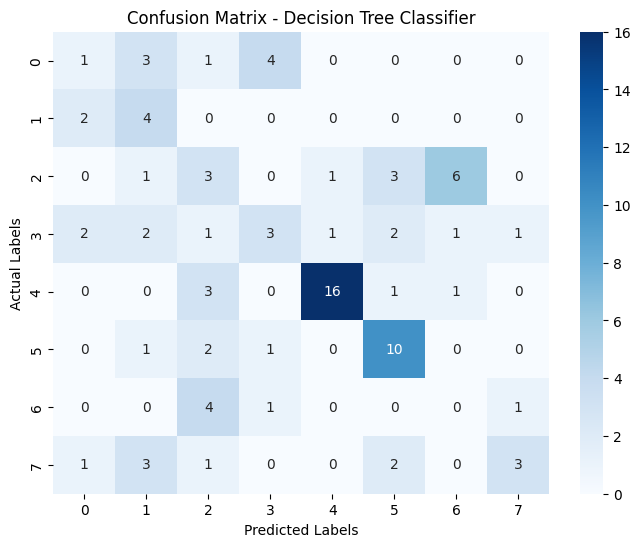

In [ ]:
# Reshape BERT embeddings to 2D (flatten the sequence_length dimension)
train_embeddings_2d = train_embeddings.view(train_embeddings.shape[0], -1).detach().cpu().numpy()
test_embeddings_2d = test_embeddings.view(test_embeddings.shape[0], -1).detach().cpu().numpy()


# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree Classifier
decision_tree.fit(train_embeddings_2d, train_labels)

# Predict on the test set
predicted_labels_dt = decision_tree.predict(test_embeddings_2d)

# Calculate accuracy
accuracy_dt = accuracy_score(test_labels, predicted_labels_dt)
print(f"Decision Tree Classifier Accuracy: {accuracy_dt * 100:.2f}%")

# Create a confusion matrix
cm_dt = confusion_matrix(test_labels, predicted_labels_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()


# Decision trees with tf-idf

Decision Tree Classifier Accuracy: 76.88%


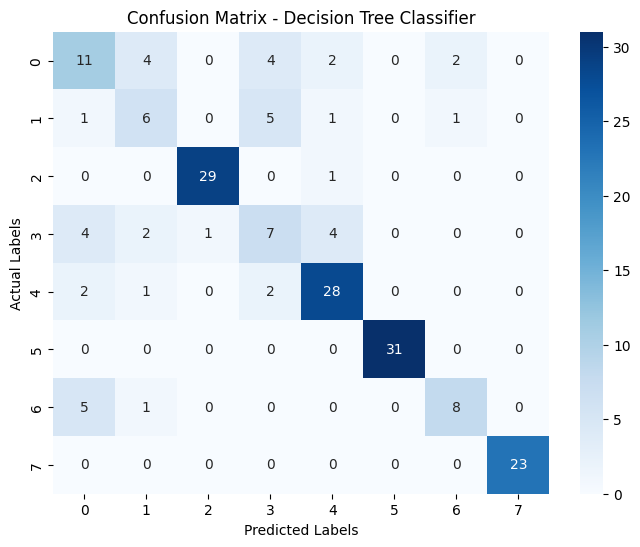

In [ ]:
# Split the dataset into training and testing sets
poems_train, poems_test, labels_train, labels_test = train_test_split(poems, labels, test_size=0.2, random_state=42)

# Convert poems into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(poems_train)
tfidf_test = vectorizer.transform(poems_test)

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree Classifier
decision_tree.fit(tfidf_train, labels_train)

# Predict on the test set
predicted_labels_dt = decision_tree.predict(tfidf_test)

# Calculate accuracy
accuracy_dt = accuracy_score(labels_test, predicted_labels_dt)
print(f"Decision Tree Classifier Accuracy: {accuracy_dt * 100:.2f}%")

# Create a confusion matrix
cm_dt = confusion_matrix(labels_test, predicted_labels_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()


# SoftMax with embeddings

Softmax Regression Classifier Accuracy: 83.87%


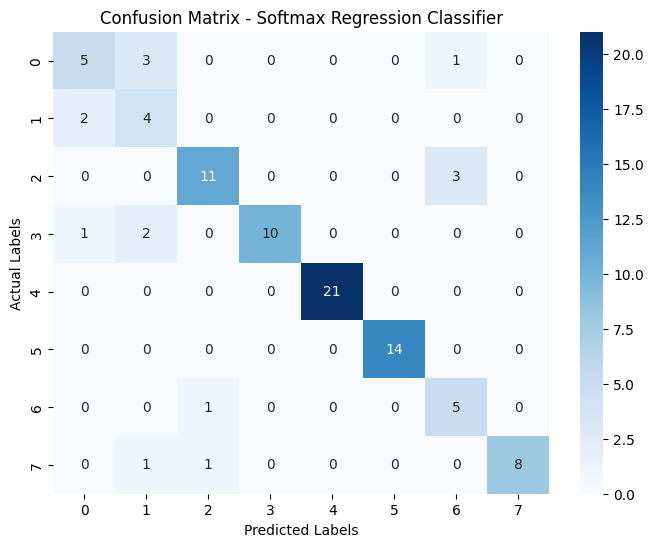

In [ ]:
# Reshape BERT embeddings to 2D (flatten the sequence_length dimension)
train_embeddings_2d = train_embeddings.view(train_embeddings.shape[0], -1).detach().cpu().numpy()
test_embeddings_2d = test_embeddings.view(test_embeddings.shape[0], -1).detach().cpu().numpy()

# Initialize the Softmax Regression (Logistic Regression) Classifier
softmax_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, max_iter=1000)

# Train the Softmax Regression Classifier
softmax_regression.fit(train_embeddings_2d, labels_train)

# Predict on the test set
predicted_labels_softmax = softmax_regression.predict(test_embeddings_2d)

# Calculate accuracy
accuracy_softmax = accuracy_score(test_labels, predicted_labels_softmax)
print(f"Softmax Regression Classifier Accuracy: {accuracy_softmax * 100:.2f}%")

# Create a confusion matrix
cm_softmax = confusion_matrix(test_labels, predicted_labels_softmax)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Softmax Regression Classifier')
plt.show()


# SoftMax with tf-idf

Softmax Regression Classifier Accuracy: 90.32%


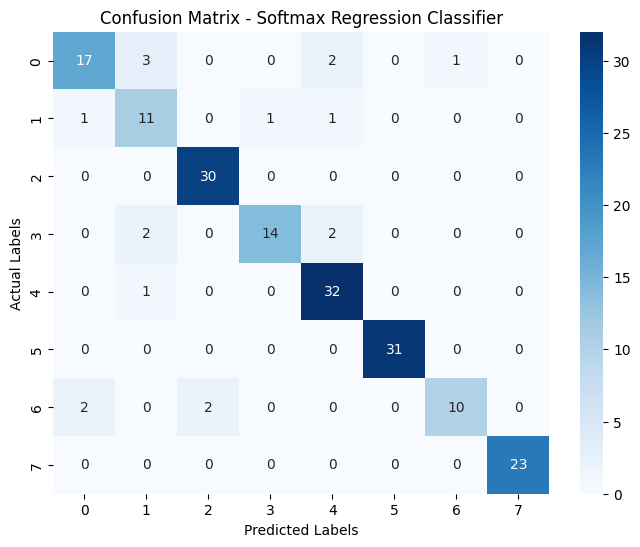

In [ ]:
# Split the dataset into training and testing sets
poems_train, poems_test, labels_train, labels_test = train_test_split(poems, labels, test_size=0.2, random_state=42)

# Convert poems into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(poems_train)
tfidf_test = vectorizer.transform(poems_test)

# Initialize the Softmax Regression (Logistic Regression) Classifier
softmax_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

# Train the Softmax Regression Classifier
softmax_regression.fit(tfidf_train, labels_train)

# Predict on the test set
predicted_labels_softmax = softmax_regression.predict(tfidf_test)

# Calculate accuracy
accuracy_softmax = accuracy_score(labels_test, predicted_labels_softmax)
print(f"Softmax Regression Classifier Accuracy: {accuracy_softmax * 100:.2f}%")

# Create a confusion matrix
cm_softmax = confusion_matrix(labels_test, predicted_labels_softmax)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Softmax Regression Classifier')
plt.show()


# SVM with embeddings

SVM Classifier Accuracy: 84.95%


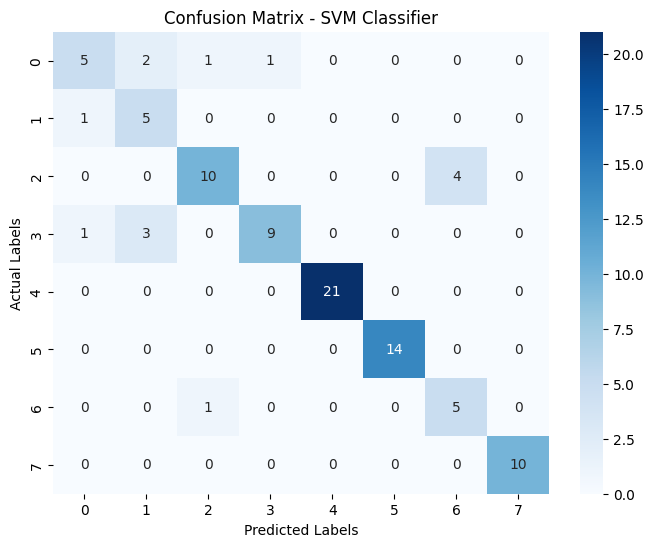

In [ ]:
# Reshape BERT embeddings to 2D (flatten the sequence_length dimension)
train_embeddings_2d = train_embeddings.view(train_embeddings.shape[0], -1).detach().cpu().numpy()
test_embeddings_2d = test_embeddings.view(test_embeddings.shape[0], -1).detach().cpu().numpy()

# Initialize the SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM Classifier
svm_classifier.fit(train_embeddings_2d, labels_train)

# Predict on the test set
predicted_labels_svm = svm_classifier.predict(test_embeddings_2d)

# Calculate accuracy
accuracy_svm = accuracy_score(test_labels, predicted_labels_svm)
print(f"SVM Classifier Accuracy: {accuracy_svm * 100:.2f}%")

# Create a confusion matrix
cm_svm = confusion_matrix(test_labels, predicted_labels_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - SVM Classifier')
plt.show()

# SVM with tf-idf

SVM Classifier Accuracy: 93.55%


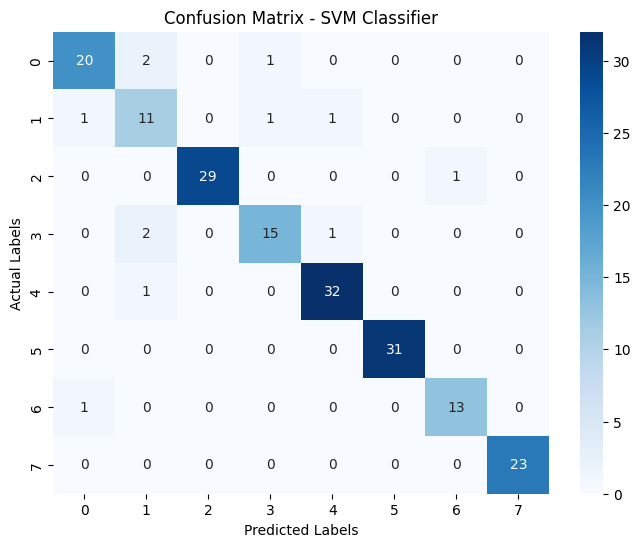

In [ ]:
# Split the dataset into training and testing sets
poems_train, poems_test, labels_train, labels_test = train_test_split(poems, labels, test_size=0.2, random_state=42)

# Convert poems into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(poems_train)
tfidf_test = vectorizer.transform(poems_test)

# Initialize the SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM Classifier
svm_classifier.fit(tfidf_train, labels_train)

# Predict on the test set
predicted_labels_svm = svm_classifier.predict(tfidf_test)

# Calculate accuracy
accuracy_svm = accuracy_score(labels_test, predicted_labels_svm)
print(f"SVM Classifier Accuracy: {accuracy_svm * 100:.2f}%")

# Create a confusion matrix
cm_svm = confusion_matrix(labels_test, predicted_labels_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - SVM Classifier')
plt.show()


# Random Forest with embeddings

Random Forest Classifier Accuracy: 73.12%


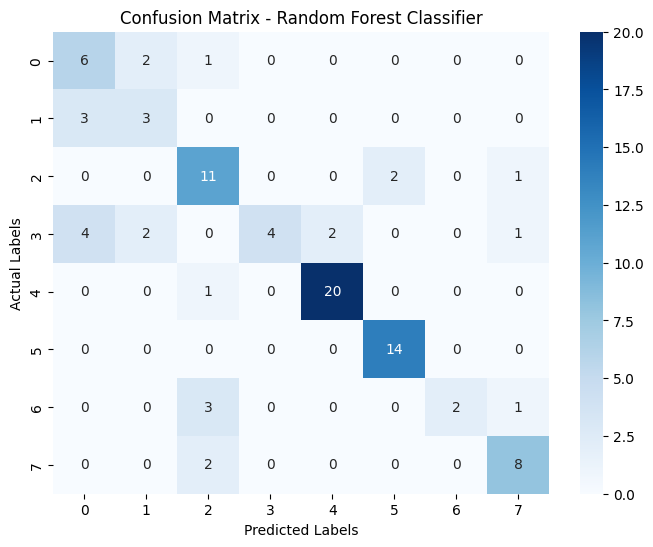

In [ ]:
# Reshape BERT embeddings to 2D (flatten the sequence_length dimension)
train_embeddings_2d = train_embeddings.view(train_embeddings.shape[0], -1).detach().cpu().numpy()
test_embeddings_2d = test_embeddings.view(test_embeddings.shape[0], -1).detach().cpu().numpy()

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=150, random_state=42)

# Train the Random Forest Classifier
random_forest.fit(train_embeddings_2d, train_labels)

# Predict on the test set
predicted_labels_rf = random_forest.predict(test_embeddings_2d)

# Calculate accuracy
accuracy_rf = accuracy_score(test_labels, predicted_labels_rf)
print(f"Random Forest Classifier Accuracy: {accuracy_rf * 100:.2f}%")

# Create a confusion matrix
cm_rf = confusion_matrix(test_labels, predicted_labels_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

# Random Forest with tf-idf


Random Forest Classifier Accuracy: 88.17%


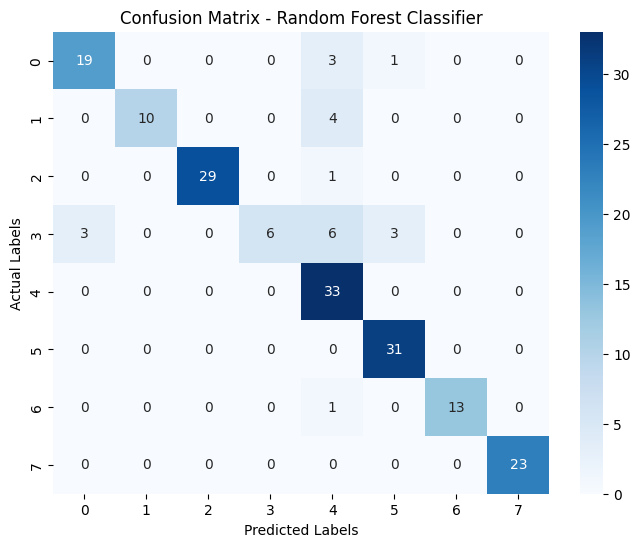

In [ ]:
# Split the dataset into training and testing sets
poems_train, poems_test, labels_train, labels_test = train_test_split(poems, labels, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Convert poems into TF-IDF vectors
tfidf_train = vectorizer.fit_transform(poems_train)
tfidf_test = vectorizer.transform(poems_test)

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest Classifier
random_forest.fit(tfidf_train, labels_train)

# Predict on the test set
predicted_labels_rf = random_forest.predict(tfidf_test)

# Calculate accuracy
accuracy_rf = accuracy_score(labels_test, predicted_labels_rf)
print(f"Random Forest Classifier Accuracy: {accuracy_rf * 100:.2f}%")

# Create a confusion matrix
cm_rf = confusion_matrix(labels_test, predicted_labels_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()